## Import

In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import numpy as np

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## EDA

In [4]:
df = pd.read_csv('../input/dai-csv/EDA__DAI.csv')
df.head(5)

,image_name,width,height,source,class,xmin,ymin,xmax,ymax
0,Pias (263).jpg,854.0,480.0,Unknown,minivan,514.0,254.0,854.0,467.0
1,Pias (263).jpg,854.0,480.0,Unknown,motorbike,429.0,397.0,563.0,480.0
2,Pias (263).jpg,854.0,480.0,Unknown,motorbike,283.0,286.0,367.0,413.0
3,Pias (263).jpg,854.0,480.0,Unknown,motorbike,1.0,295.0,71.0,427.0
4,Pias (263).jpg,854.0,480.0,Unknown,motorbike,41.0,285.0,108.0,345.0


In [5]:
df_new = df[['image_name']].copy()

In [6]:
df_new.rename(columns={'image_name':'image_id'} , inplace=True)

In [7]:
df_new.loc[:,'width'] = df[['width']].copy()

In [8]:
df_new.loc[:,'height'] = df[['height']].copy()
df_new.loc[:,'xmin'] = df[['xmin']].copy()
df_new.loc[:,'ymin'] = df[['ymin']].copy()
df_new.loc[:,'xmax'] = df[['xmax']].copy()
df_new.loc[:,'ymax'] = df[['ymax']].copy()

In [9]:
df_new.head(5)

,image_id,width,height,xmin,ymin,xmax,ymax
0,Pias (263).jpg,854.0,480.0,514.0,254.0,854.0,467.0
1,Pias (263).jpg,854.0,480.0,429.0,397.0,563.0,480.0
2,Pias (263).jpg,854.0,480.0,283.0,286.0,367.0,413.0
3,Pias (263).jpg,854.0,480.0,1.0,295.0,71.0,427.0
4,Pias (263).jpg,854.0,480.0,41.0,285.0,108.0,345.0


In [10]:
df_new.loc[:,'w'] = df_new.loc[:,'xmax'] - df_new.loc[:,'xmin']
df_new.loc[:,'h'] = df_new.loc[:,'ymax'] - df_new.loc[:,'ymin']

In [11]:
marking = df_new

In [12]:
marking

,image_id,width,height,xmin,ymin,xmax,ymax,w,h
0,Pias (263).jpg,854.0,480.0,514.0,254.0,854.0,467.0,340.0,213.0
1,Pias (263).jpg,854.0,480.0,429.0,397.0,563.0,480.0,134.0,83.0
2,Pias (263).jpg,854.0,480.0,283.0,286.0,367.0,413.0,84.0,127.0
3,Pias (263).jpg,854.0,480.0,1.0,295.0,71.0,427.0,70.0,132.0
4,Pias (263).jpg,854.0,480.0,41.0,285.0,108.0,345.0,67.0,60.0
...,...,...,...,...,...,...,...,...,...
24363,Navid_609.jpg,4096.0,2304.0,1436.0,1174.0,1543.0,1338.0,107.0,164.0
24364,Navid_609.jpg,4096.0,2304.0,1385.0,1181.0,1432.0,1336.0,47.0,155.0
24365,Navid_609.jpg,4096.0,2304.0,1059.0,1206.0,1295.0,1354.0,236.0,148.0
24366,Navid_609.jpg,4096.0,2304.0,277.0,1167.0,686.0,1563.0,409.0,396.0


In [13]:
marking.rename(columns={'xmin':'x','ymin':'y'},inplace=True)

In [14]:
marking.drop(columns=['xmax','ymax'],inplace=True)

In [15]:
marking.loc[:,'class'] =df[['class']].copy()

In [16]:
marking.head(5)

,image_id,width,height,x,y,w,h,class
0,Pias (263).jpg,854.0,480.0,514.0,254.0,340.0,213.0,minivan
1,Pias (263).jpg,854.0,480.0,429.0,397.0,134.0,83.0,motorbike
2,Pias (263).jpg,854.0,480.0,283.0,286.0,84.0,127.0,motorbike
3,Pias (263).jpg,854.0,480.0,1.0,295.0,70.0,132.0,motorbike
4,Pias (263).jpg,854.0,480.0,41.0,285.0,67.0,60.0,motorbike


## Data Spilitting

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'stratify_group'] = np.char.add(
    'stratify',
    df_folds['bbox_count'].apply(lambda x: f'_{x // 5}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [19]:
df_folds.to_csv('Stratified__bbox.csv' , index=True)

In [20]:
df_folds.head(5)

,bbox_count,stratify_group,fold
image_id,,,
01.jpg,30,stratify_6,0
02.jpg,31,stratify_6,0
03.jpg,5,stratify_1,1
04.jpg,15,stratify_3,1
05.jpg,34,stratify_6,2


In [21]:
len(df_folds.index.values)

3002

## Label Encoding

In [22]:
le = preprocessing.LabelEncoder()

In [23]:
le.fit(marking['class'].values)

LabelEncoder()

In [24]:
encoded_class = le.transform(marking['class'].values)

In [25]:
set(encoded_class)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [26]:
marking.loc[:,'en_class'] = encoded_class

In [27]:
marking

,image_id,width,height,x,y,w,h,class,en_class
0,Pias (263).jpg,854.0,480.0,514.0,254.0,340.0,213.0,minivan,9
1,Pias (263).jpg,854.0,480.0,429.0,397.0,134.0,83.0,motorbike,10
2,Pias (263).jpg,854.0,480.0,283.0,286.0,84.0,127.0,motorbike,10
3,Pias (263).jpg,854.0,480.0,1.0,295.0,70.0,132.0,motorbike,10
4,Pias (263).jpg,854.0,480.0,41.0,285.0,67.0,60.0,motorbike,10
...,...,...,...,...,...,...,...,...,...
24363,Navid_609.jpg,4096.0,2304.0,1436.0,1174.0,107.0,164.0,rickshaw,13
24364,Navid_609.jpg,4096.0,2304.0,1385.0,1181.0,47.0,155.0,rickshaw,13
24365,Navid_609.jpg,4096.0,2304.0,1059.0,1206.0,236.0,148.0,car,5
24366,Navid_609.jpg,4096.0,2304.0,277.0,1167.0,409.0,396.0,suv,15


In [28]:
val, idx = min((val, idx) for (idx, val) in enumerate(marking['width'].values))

In [29]:
idx

13621

## Augmentation

In [30]:
def get_train_transforms():
    return A.Compose(
        [
            A.Resize(1024,1024,p=1),
            A.RandomSizedCrop(min_max_height=(1000, 1000), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            #A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=10, max_h_size=20, max_w_size=20, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [31]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset Trial

In [32]:
TRAIN_ROOT_PATH = '../input/dhakaai-2020/dhaka.ai train/Final Train Dataset'

In [33]:
image_ids=df_folds[df_folds['fold'] != 0 ].index.values
image_id = image_ids[0]

In [34]:
image_id

'03.jpg'

In [35]:
image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

In [36]:
records = marking[marking['image_id'] == image_id]
boxes = records[['x', 'y', 'w', 'h']].values

In [37]:
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

In [38]:
boxes

array([[504.,  19., 712., 314.],
       [396.,  85., 518., 285.],
       [726., 205., 751., 246.],
       [693., 157., 718., 241.],
       [687., 228., 704., 276.]])

In [39]:
labels = torch.tensor(records['en_class'].values)

In [40]:
labels

tensor([18,  4, 13, 18, 10])

In [41]:
target = {}
target['boxes'] = boxes
target['labels'] = labels
target['image_id'] = torch.tensor([0])

In [42]:
transforms=get_train_transforms()

In [43]:
sample = transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })

In [44]:
image = sample['image']
target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning

In [45]:
target

{'boxes': tensor([[ 20.6006, 329.2774, 364.3005, 465.5923],
         [ 97.4962, 258.4986, 330.5131, 338.4525],
         [237.3063, 474.7674, 285.0748, 491.1514],
         [181.3823, 453.1405, 279.2494, 469.5245],
         [264.1033, 449.2083, 320.0273, 460.3494]], dtype=torch.float64),
 'labels': tensor([18,  4, 13, 18, 10]),
 'image_id': tensor([0])}

## Final Dataset

In [46]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            #image, boxes = self.load_cutmix_image_and_boxes(index)
            image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        records = self.marking[self.marking['image_id'] == image_id]
        labels = torch.tensor(records['en_class'].values)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        records = self.marking[self.marking['image_id'] == image_id]
        
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR)
        
        width = records[['width']].values[0][0]
        height = records[['height']].values[0][0]
        
        if image is None:
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{os.path.splitext(image_id)[0]}.jpeg', cv2.IMREAD_COLOR)
            
        if image is None:
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{os.path.splitext(image_id)[0]}.png', cv2.IMREAD_COLOR)
            
        if image is None:
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{os.path.splitext(image_id)[0]}.JPG', cv2.IMREAD_COLOR)
            
        if image is None:
            image = cv2.imread(f'{TRAIN_ROOT_PATH}/{os.path.splitext(image_id)[0]}.PNG', cv2.IMREAD_COLOR)
            
        if ((int(width)!=0) & (int(height)!=0)):
            image = cv2.resize(image , (int(width),int(height)))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [47]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

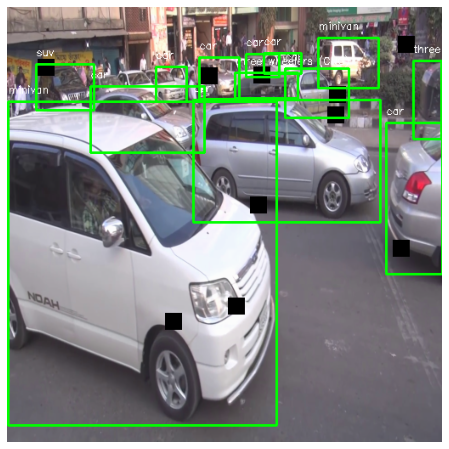

In [48]:
image, target, image_id = train_dataset[1005]
boxes = target['boxes'].cpu().numpy().astype(np.int32)
labels = target['labels'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i,box in enumerate(boxes):
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    cv2.putText(numpy_image,le.inverse_transform([labels[i]])[0] , (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (36,255,12), 1)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Checking

In [49]:
#for i in range(len(train_dataset)):
    #image, target, image_id = train_dataset[i]

## Meter

In [50]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Config

In [51]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 40  # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

## Model

In [52]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 21
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config).cuda()

net = get_net()

## Fitter

In [53]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

## Running

In [54]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [55]:
def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [56]:
run_training()

Fitter prepared. Device is cuda:0

2020-10-11T18:59:04.770106
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 249.30766, time: 523.03060
[RESULT]: Val. Epoch: 0, summary_loss: 11.33505, time: 53.06928

2020-10-11T19:08:42.813068
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 4.06705, time: 517.63860
[RESULT]: Val. Epoch: 1, summary_loss: 2.79502, time: 49.36603

2020-10-11T19:18:12.139459
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 1.80593, time: 514.15043
[RESULT]: Val. Epoch: 2, summary_loss: 1.70516, time: 49.32040

2020-10-11T19:27:37.987194
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 1.23205, time: 513.19566
[RESULT]: Val. Epoch: 3, summary_loss: 1.23428, time: 50.00596

2020-10-11T19:37:03.515862
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.97384, time: 519.42184
[RESULT]: Val. Epoch: 4, summary_loss: 1.05884, time: 51.81286

2020-10-11T19:46:36.910276
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.81493, time: 529.39557
[RESULT]: Val. Epo